In [1]:
import numpy as np
import psana as ps
import matplotlib.pyplot as plt
import sys
import time
import pickle
import os
from Functions import *
from raw_data_class import RawData as RDC
#from processed_data_class import ProData as PDC
%matplotlib notebook

In [30]:
save_dir = '/cds/home/b/bpoult/sample_data/'
calib_dir = '/cds/home/b/bpoult/LCLS_LV_27_Data_Analysis/calibrations/'
runs = list(range(230,239)) # goes from first value in range to last - 1
epix_roi = [80,140,170,330]
xrt_roi = [725,1500]
calibration_file = 'calibration_2'

# Processing or Loading
process_raw = False
on_off = True # Do you want to plot the raw data?
plot_one = 238
x_axis = 'energy' # 'pixels' or 'energy'
to_cal_file = [calib_dir, calibration_file]

In [31]:
# Energy Calibration, plot raw calibration runs with pixel axis and populate these arrays
save_cal = False
if save_cal is True:
    calib_runs = list(range(230,238))
    notch_energies = [6.985,6.990,6.995,7.000,7.005,7.010,7.015,7.020] # keV
    xrt_pixels = [1412,1321,1237,1150,1065,980,896,810] # enter 0 if you can't see the notch
    epix_pixels = [0,243,256,269,282,295,0,0] # enter 0 if you can't see the notch

    labels = ['notch_energies','xrt_pixels','epix_pixels','rois','to_cal_file','calib_runs']
    rois = [xrt_roi,epix_roi]
    calib_in = [labels, notch_energies,xrt_pixels,epix_pixels,rois,to_cal_file,calib_runs]
    calib_out = energy_calib.energy_calib(calib_in,save_cal)
    print('')
    print('The loaded calibration settings are: ')
    current_cal = [print(calib_out[0][i] +' : '+ str(calib_out[i+1])) for i in list(range(0,5))+list(range(8,10))]
if os.path.exists(to_cal_file[0]+to_cal_file[1]+'.pkl') and save_cal is False:
    with open(to_cal_file[0] + to_cal_file[1] +'.pkl', "rb") as f:
        calib_out = pickle.load(f)
    print('The loaded calibration settings are: ')
    current_cal = [print(calib_out[0][i] +' : '+ str(calib_out[i+1])) for i in list(range(0,5))+list(range(8,10))]   
    
if not os.path.exists(to_cal_file[0]+to_cal_file[1]+'.pkl'):
    print(to_cal_file[1] + ' does not exist.')
    print('No calibration file loaded.')

The loaded calibration settings are: 
notch_energies : [6.985, 6.99, 6.995, 7.0, 7.005, 7.01, 7.015, 7.02]
xrt_pixels : [1412, 1321, 1237, 1150, 1065, 980, 896, 810]
epix_pixels : [0, 243, 256, 269, 282, 295, 0, 0]
rois : [[725, 1500], [80, 140, 170, 330]]
to_cal_file : ['/cds/home/b/bpoult/LCLS_LV_27_Data_Analysis/calibrations/', 'calibration_2']
epix_motor : 32.18824
time_calibrated : 2021-05-24 09:19:22.159240


exp=cxix46119:run=230:smd
exp=cxix46119:run=231:smd
exp=cxix46119:run=232:smd
exp=cxix46119:run=233:smd
exp=cxix46119:run=234:smd
exp=cxix46119:run=235:smd
exp=cxix46119:run=236:smd
exp=cxix46119:run=237:smd
exp=cxix46119:run=238:smd


<IPython.core.display.Javascript object>


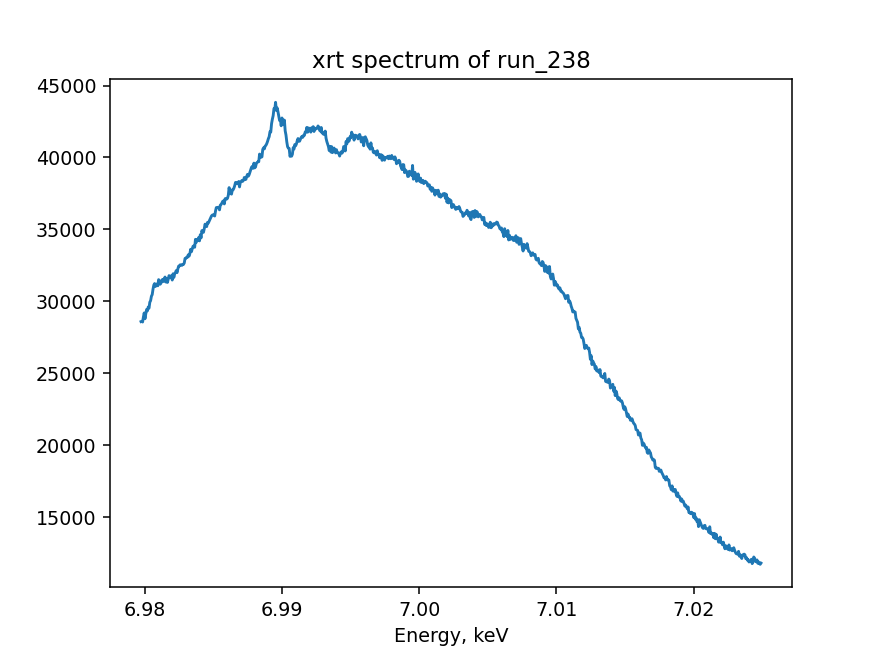

<IPython.core.display.Javascript object>


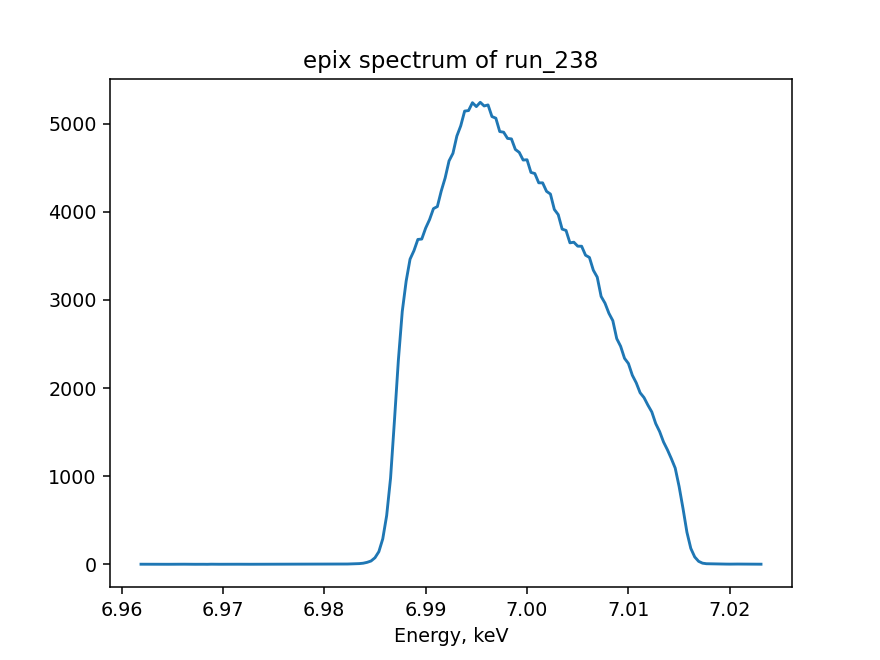

<IPython.core.display.Javascript object>


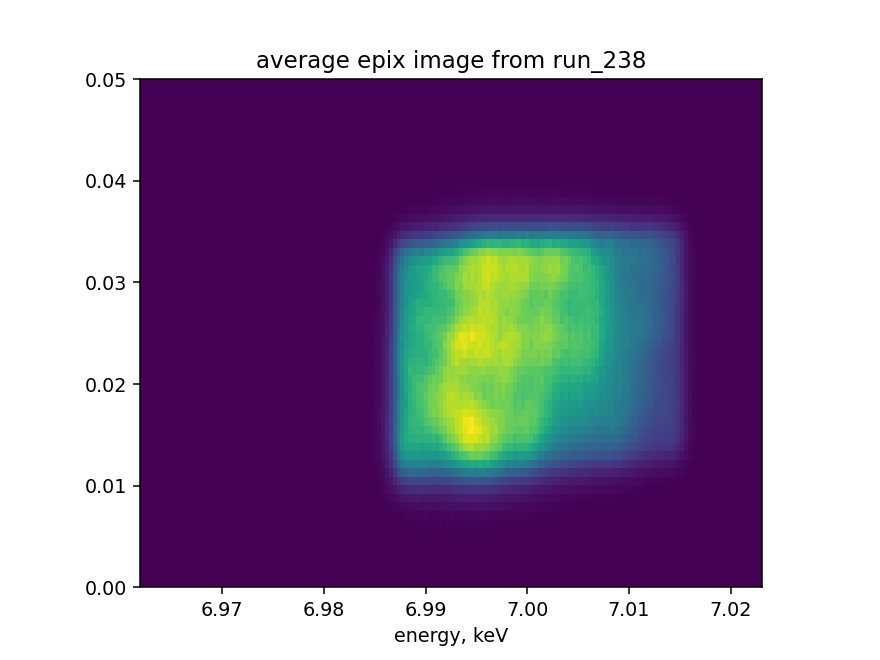

<IPython.core.display.Javascript object>


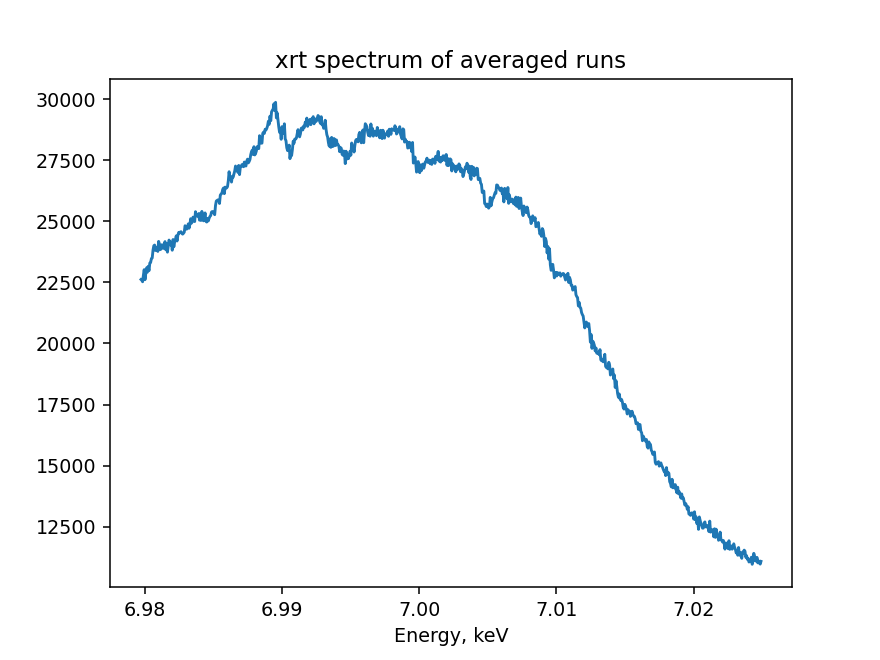

<IPython.core.display.Javascript object>


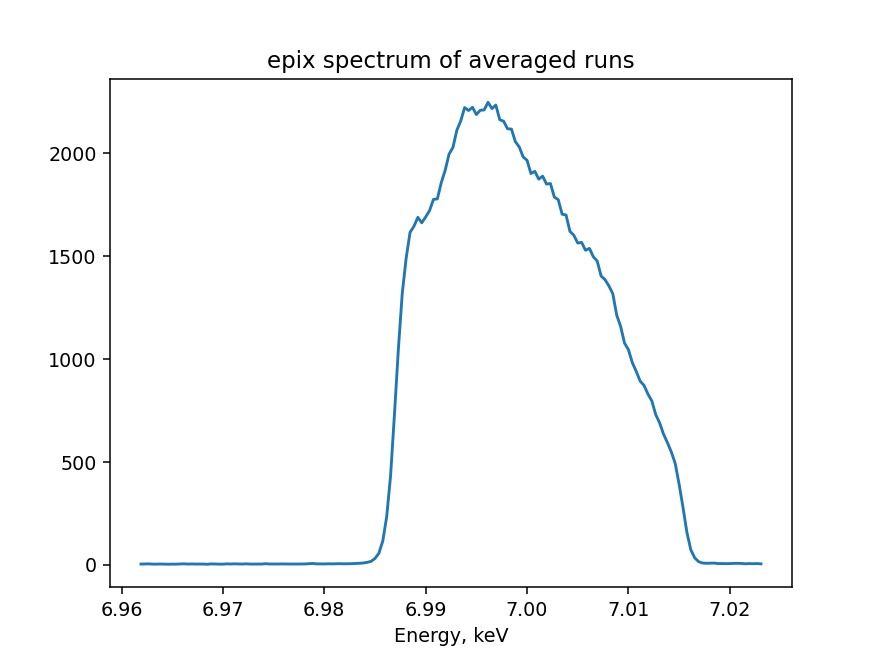

In [43]:
# Raw Data
raw_datas = []
for run in runs:
    scan_name = 'run_' + f'{run:03}'
    ds_string = 'exp=cxix46119:run='+str(run)+':smd'
    print(ds_string)
    if process_raw:
        raw_data = load_data.load_data(save_dir,scan_name,ds_string,epix_roi,xrt_roi)
    else:
        if os.path.exists(save_dir + scan_name + "/" + "rawdata.pkl"):
            with open(save_dir + scan_name + "/" + "rawdata.pkl", "rb") as f:
                raw_data = pickle.load(f)
        else:
            print('You are trying to load a file that does not exist.')
    if os.path.exists(save_dir + scan_name + "/" + "rawdata.pkl"):
        raw_datas = raw_datas + [raw_data]

[load_data.add_cal_info(raw_datas[i],to_cal_file) for i in range(0,len(raw_datas))]
plot_raw.plot_raw(raw_datas, plot_one, x_axis, on_off,to_cal_file)

In [87]:
# Overlapping Data: matches energy ranges, resolutions, spectrometer response, and normalizes
# Need to have new directory inputs that correspond to pump only or probe only runs.
print(calib_out[0])
energy_window = [6.986,7.0158]
epix_window = np.logical_and(calib_out[8] > energy_window[0],calib_out[8] < energy_window[1])
xrt_window = np.logical_and(calib_out[7] > energy_window[0],calib_out[7] < energy_window[1]) 
epix_windowed = [calib_out[8][epix_window],np.mean(raw_data.epix_spectrum,0)[epix_window]]
xrt_windowed = [calib_out[7][xrt_window],np.mean(raw_data.xrt_spectrum,0)[xrt_window]]
column_compress = reduce_matrix_size.get_column_compressor(epix_windowed[0].shape[0],xrt_windowed[0].shape[0])
#output = reduce_matrix_size.compress_and_average(xrt_windowed[1][np.newaxis,:],epix_windowed[1][np.newaxis,:].shape)
#epix_y = epix_windowed[1]
#xrt_y = np.flip(np.squeeze(np.asarray(output)))
#energy = epix_windowed[0]

# plt.figure()
# plt.plot(energy,epix_y)
# plt.plot(energy,xrt_y)
# plt.show()

# scaling = np.max(epix_y)/np.max(xrt_y)
# scaling2 = np.divide(xrt_y,epix_y)*scaling
# scaling3 = scaling2/np.max(scaling2)

# plt.figure()
# plt.plot(energy,epix_y)
# plt.plot(energy,xrt_y)
# plt.show()

['notch_energies', 'xrt_pixels', 'epix_pixels', 'rois', 'to_cal_file', 'calib_runs', 'xrt_energy', 'epix_energy', 'epix_motor', 'time_calibrated']


dict_keys(['eventIDs', 'photon_energies', 'I0_fee', 'high_diode_us', 'low_diode_us', 'epix_roi', 'xrt_roi', 'epix_spectrum', 'xrt_spectrum', 'avg_epix_2d', 'xrt_intensity', 'epix_intensity', 'scan_name', 'epix_motor', 'pulse_energies_fee', 'save_dir', 'ds_string', 'calibration_info', 'previous_cal'])
[ 1.18727303 -0.34082857]
[1.26503899 1.33462037 1.23109436 ... 1.55522767 1.32904772 1.45349602]
1.265038992026703
0.23074546
-0.7349610079732971


<IPython.core.display.Javascript object>


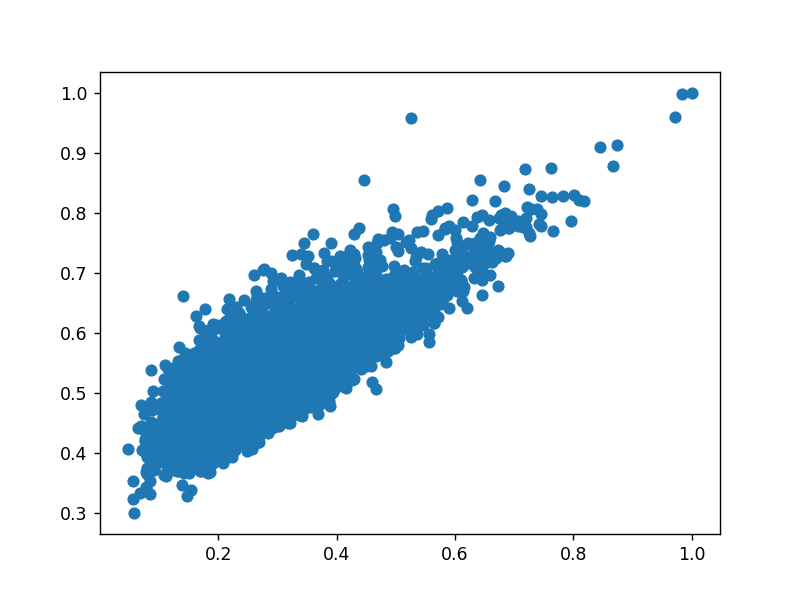

In [41]:
# Inputs for filters
print(raw_data.getKeys())
# filters = [filter0,filter1, ...,filterN]

            # filterX[0] = On/Off # True or False
            # filterX[1] = Type # 'linearity','bounds','rms'
            # filterX[2] = [par0,par1,...,parN]
            
                # If Type = 'bounds'    # par0 = 'key_0' # key_X is string from raw_data.getKeys()
                                        # par1 = lower bound # check raw_data.keyX for starting point 
                                        # par2 = upper bound # 'None' if no upper bound
                                        # par3 = number of stds from median allowed
            
                # If Type = 'linearity' # par0 = 'key_0','key_1' # key_0 and key_1 and x and y values, respectively
                                        # par1 = width of filter
                        
                # If Type = 'rms'       # TBD
                
# filterX[3] = plot_on # True or False
filter0 = [True,'bounds',['low_diode_us',np.min(raw_data.low_diode_us),'None',1],False]
filter1 = [True,'bounds',['high_diode_us',np.min(raw_data.high_diode_us),'None',1],False]
filter2 = [True,'linearity',['xrt_intensity','epix_intensity',1],False]
filters = [filter0,filter1,filter2]
output1,output2 = Filters.filtering(raw_data,filters)
all_events = raw_data.eventIDs
#good_indicies = all_events.searchsorted(output)
#output == all_events[good_indicies]
#print(len(output),len(good_indicies),len(all_events))
#all(output == all_events[good_indicies])
#print(output1)
#print(output2)
output = Filters.lin_filter(raw_data,filter2[2])
#plt.figure()
#plt.scatter(raw_data.epix_intensity/max(raw_data.epix_intensity),raw_data.xrt_intensity/max(raw_data.xrt_intensity))
#plt.show()
output
var_x = getattr(raw_data,filter2[2][0])
var_y = getattr(raw_data,filter2[2][1])
var_x = var_x/max(var_x)
var_y = var_y/max(var_y)

lin_fit = np.polyfit(var_x, var_y, 1)

cond_lin_high = var_y < var_x * lin_fit[0] + lin_fit[1] + filter2[2][2]
cond_lin_low = var_y > var_x * lin_fit[0] + lin_fit[1] - filter2[2][2]

condition = cond_lin_high & cond_lin_low
print(lin_fit)
print(var_x * lin_fit[0] + lin_fit[1] + filter2[2][2])
print(var_x[0]* lin_fit[0]+ lin_fit[1] + filter2[2][2])
print(var_y[0])
print(var_x[0] * lin_fit[0] + lin_fit[1] - filter2[2][2])
plt.figure()
plt.scatter(raw_data.epix_intensity/max(raw_data.epix_intensity),raw_data.xrt_intensity/max(raw_data.xrt_intensity))
plt.show()

In [7]:
# Filtering Raw Data: filter[0] = 'filter_name'
                    # filter[1] = True/False to turn on/off that filter
                    # filter[2:end] = 1 value per index